# Artificial Neural Networks in Regression analysis
### Using Household and Transportation (% of income) to Predict Accessibility

In a regression problem, we aim to predict the output of a continuous value, in this case, the level of private accessibility over 10 minutes on the road network for blocks in Los Angeles County. 

In [3]:
from __future__ import absolute_import, division, print_function

import pathlib
import pickle
import seaborn as sns


import pandas as pd
import numpy as np
pd.options.display.max_rows = 10

#import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
%matplotlib inline

1.12.0


In [59]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


In [91]:
Sample_Data_null = Data_clean_all_col.iloc[:, [15]]
Sample_Data_null

,Tot_r_10
0,9407.8979
1,10492.4500
2,10283.7200
3,10238.5000
4,11543.9900
...,...
16465,92774.4534
16466,91699.3770
16467,91699.3770
16468,89253.7904


In [10]:
Sample_Data_clean = Data_clean_all_col.iloc[:, [15,51]]
Sample_Data_clean

,Tot_r_10,ht_ami
0,9407.8979,60.000000
1,10492.4500,60.000000
2,10283.7200,60.000000
3,10238.5000,60.000000
4,11543.9900,57.000000
5,8894.0200,65.000000
6,12047.7300,45.000000
7,11998.8900,45.000000
8,12670.1157,45.000000
9,11203.8700,47.000000


#### Split the data into train and test
Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [37]:
train_dataset_null = Sample_Data_null.sample(frac=0.8,random_state=0)
test_dataset_null = Sample_Data_null.drop(train_dataset.index)
test_dataset_null

,Tot_r_10
0,9407.8979
13,13052.2800
21,20115.7300
25,12751.4857
26,11355.1029
27,11578.7851
28,12208.4800
35,9195.4021
41,13406.1800
43,15071.8846


In [11]:
train_dataset = Sample_Data_clean.sample(frac=0.8,random_state=0)
test_dataset = Sample_Data_clean.drop(train_dataset.index)
test_dataset

,Tot_r_10,ht_ami
0,9407.8979,60.000000
13,13052.2800,47.000000
21,20115.7300,75.000000
25,12751.4857,55.000000
26,11355.1029,55.000000
27,11578.7851,74.000000
28,12208.4800,69.000000
35,9195.4021,75.000000
41,13406.1800,67.000000
43,15071.8846,69.354022


#### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

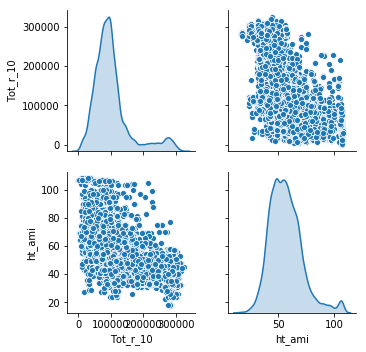

In [12]:
sns.pairplot(train_dataset[["Tot_r_10", "ht_ami"]], diag_kind="kde")


In [92]:
train_stats_null = train_dataset_null.describe()
train_stats_null = train_stats_null.transpose()
train_stats_null

,count,mean,std,min,25%,50%,75%,max
Tot_r_10,13176.0,102966.252914,57344.527203,168.7039,68556.6795,91635.6639,116788.969375,324814.2688


In [13]:
train_stats = train_dataset.describe()
train_stats.pop("Tot_r_10")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ht_ami,13176.0,56.879521,14.405075,17.0,47.0,55.0,65.0,108.0


#### Split features from labels
Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [114]:
train_labels_null = train_dataset_null.pop('Tot_r_10')
test_labels_null = train_dataset_null.pop('Tot_r_10')

KeyError: 'Tot_r_10'

In [106]:
train_labels = train_dataset.pop('Tot_r_10')
test_labels = test_dataset.pop('Tot_r_10')

#### Normalize the data
Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [94]:
def norm(x):
    return (x - train_stats_null['mean']) / train_stats_null['std']

In [95]:
normed_train_data_null = norm(train_dataset_null)
normed_test_data_null = norm(test_dataset_null)

In [16]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [17]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [108]:
Dense = tf.keras.layers.Dense

In [109]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [110]:
model = build_model()

#### Inspect the model

Use the `.summary` method to print a simple description of the model

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of 10 examples from the training data and call `model.predict` on it.

In [112]:
example_batch_null = normed_train_data_null[:10]
example_result_null = model.predict(example_batch_null)
example_result_null

array([[0.10717219],
       [0.0056867 ],
       [0.02136312],
       [0.040375  ],
       [0.12965804],
       [0.00347274],
       [0.0468375 ],
       [0.10301421],
       [0.09797521],
       [0.0045677 ]], dtype=float32)

#### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [115]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data_null, train_labels_null,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [117]:
hist_null = pd.DataFrame(history.history)
hist_null['epoch'] = hist_null.epoch
hist_null.to_csv('hist_ANN0.csv', sep=',')
hist_null.tail()

AttributeError: 'DataFrame' object has no attribute 'epoch'

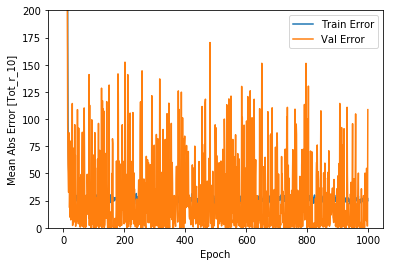

In [123]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Tot_r_10]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim([0,200])
    plt.savefig("ANN1.png", format="PNG")



plot_history(history)


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('hist_ANN1.csv', sep=',')
hist.tail()

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Tot_r_10]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim([32000,40000])
    plt.savefig("ANN1.png", format="PNG")



plot_history(history)


# Saving and re-loading the model
## for Null model

In [124]:
model.save('./ANN_null.model')

In [125]:
model_from_save = tf.keras.models.load_model('ANN_null.model')

In [126]:
full_normed_data = norm(Data_clean_all_col[['Tot_r_10']]).values

In [127]:
prediction = model_from_save.predict(full_normed_data)

In [128]:
prediction = pd.DataFrame(prediction, columns=['predictions']).to_csv('prediction_ANN_0.csv')

In [155]:
predictions_MLM_null = pd.read_csv('./Pred_1_trans.csv')
predictions_MLM_null.head()

,Unnamed: 0,1999
0,y_hat[1],4.422776
1,y_hat[2],4.422776
2,y_hat[3],4.422776
3,y_hat[4],4.422776
4,y_hat[5],3.364825


In [156]:
predictions_ANN_null = pd.read_csv('./prediction_ANN_0.csv')
predictions_ANN_null.head()

,Unnamed: 0,predictions
0,0,9441.088
1,1,10524.009
2,2,10315.592
3,3,10270.440
4,4,11573.969


In [158]:
y_pred_ANN_null = predictions_ANN_null['predictions']
y_pred_MLM_null = predictions_MLM_null['1999']
y_true = Data_clean_all_col['Tot_r_10']

In [141]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [159]:
r2(y_pred_ANN_null, y_true)

0.9999942220287948

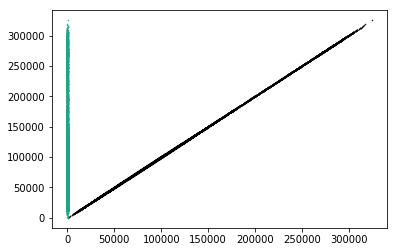

In [160]:
plt.scatter(y_pred_ANN_null, y_true,color='k', marker='.', s=1)
plt.scatter(y_pred_MLM_null, y_true,color='#20A387', marker='.', s=1)

plt.show()

In [161]:
import sklearn 
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred_ANN_null)

108.24336689799622

In [162]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred_ANN_null): 
    y_true, y_pred_ANN_null = check_array(y_true, y_pred_ANN_null)
return np.mean(np.abs((y_true - y_pred_ANN_null) / y_true)) * 100

0.09667527884557828

## for Model 1

In [52]:
model.save('./ANN_ht_ami.model')

In [53]:
model_from_save = tf.keras.models.load_model('ANN_ht_ami_.model')

In [54]:
full_normed_data = norm(Data_clean_all_col[['ht_ami']]).values

In [55]:
prediction = model_from_save.predict(full_normed_data)

ValueError: Error when checking input: expected dense_9_input to have shape (1,) but got array with shape (2,)

In [ ]:
prediction = pd.DataFrame(prediction, columns=['predictions']).to_csv('prediction_ANN_1.csv')

In [48]:
prediction = pd.DataFrame(prediction, columns=['predictions']).to_csv('prediction_ANN_1.csv')

In [86]:
prediction_MLM = pd.read_csv('./Fit_2/Pred_6000_20000_trans_fit_2.csv')
prediction_MLM.head()

,Unnamed: 0,1999
0,y_hat[1],14996.785691
1,y_hat[2],14996.785691
2,y_hat[3],14996.785691
3,y_hat[4],14996.785691
4,y_hat[5],30264.866235


In [87]:
prediction_ANN = pd.read_csv('./ANN_1/prediction_ANN_1.csv')
prediction_ANN.head()

,Unnamed: 0,predictions
0,0,93241.01
1,1,93241.01
2,2,93241.01
3,3,93241.01
4,4,101879.05


In [148]:
y_pred_ANN = prediction_ANN['predictions']
y_pred_MLM = prediction_MLM['1999']
y_true = Data_clean_all_col['Tot_r_10']

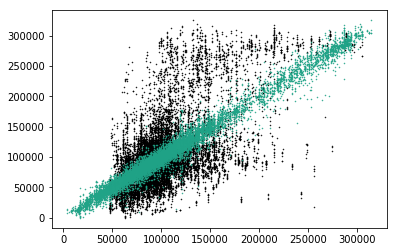

In [90]:
plt.scatter(y_pred_ANN, y_true,color='k', marker='.', s=1)
plt.scatter(y_pred_MLM, y_true,color='#20A387', marker='.', s=1)

plt.show()

In [80]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [149]:
r2(y_pred_ANN, y_true)

0.3520338144001264

In [150]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred_ANN)

33263.56871351548

In [153]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred_ANN): 
    y_true, y_pred_ANN = check_array(y_true, y_pred_ANN)
return np.mean(np.abs((y_true - y_pred_ANN) / y_true)) * 100


45.19859610962351

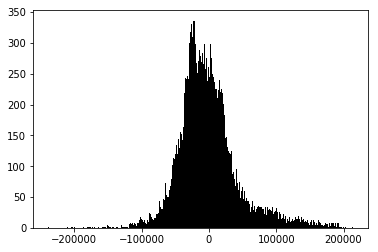

In [65]:
plt.hist(Data_clean_all_col.Tot_r_10 - predictions.predictions, bins=300, color='k')
plt.show()

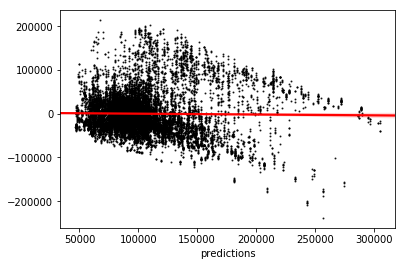

In [67]:
sns.regplot(predictions.predictions, 
            Data_clean_all_col.Tot_r_10 - predictions.predictions,
            scatter_kws=dict(color='k', marker='.', s=1), 
            line_kws=dict(color='r'))

In [68]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [70]:
r2(y_pred, y_true)

0.3520338144001264

In [4]:
model_1 = pd.read_csv('./ANN_1/prediction_ANN_1.csv')
model_1.head()

,Unnamed: 0,predictions
0,0,93241.01
1,1,93241.01
2,2,93241.01
3,3,93241.01
4,4,101879.05


In [12]:
model_2 = pd.read_csv('./ANN_2/prediction_ANN_2.csv')
model_2.head()

,Unnamed: 0,ANN_2_Tot_r_10
0,0,96832.89
1,1,96832.89
2,2,96832.89
3,3,96832.89
4,4,104029.99


In [18]:
model_3 = pd.read_csv('./ANN_3/prediction_ANN_3.csv')
model_3.head()

,Unnamed: 0,predictions
0,0,77364.130
1,1,77364.130
2,2,77364.130
3,3,77364.130
4,4,83827.266


In [23]:
model_3.quantile(q=0.975, axis=0, numeric_only=True, interpolation='linear')

Unnamed: 0      16057.275
predictions    200270.080
Name: 0.975, dtype: float64